## Classifying images with pre-trained Apache MXNet models

First, let's download three image classification models from the Apache MXNet [model zoo](http://mxnet.io/model_zoo/).
* **VGG-16**: the 2014 classification winner at the [ImageNet Large Scale Visual Recognition Challenge](http://image-net.org/challenges/LSVRC).
* **Inception v3**, an evolution of GoogleNet, the 2014 winner for object detection.
* **ResNet-152**, the 2015 winner in multiple categories.

Why would we want to try multiple models? Why don't we simply pick the one with the best accuracy? As we will see later on, even though these models have been trained on the same data set and optimized for maximum accuracy, they do behave slightly differently on **specific images**: maybe one of the models them will actually do a better job at solving your business problem. **Prediction speed** can vary a lot as well and that's an important factor for many applications.

For each model, we need to download two files:
* the **symbol** file containing the JSON definition of the neural network: layers, connections, activation functions, etc.
* the **weights** file storing values for all neuron weights, a.k.a. parameters, learned by the network during the training phase.

In [ ]:
!wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-symbol.json -O vgg16-symbol.json
!wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-0000.params -O vgg16-0000.params
!wget http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-symbol.json -O Inception-BN-symbol.json
!wget http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-0126.params -O Inception-BN-0000.params
!wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-symbol.json -O resnet-152-symbol.json
!wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-0000.params -O resnet-152-0000.params
!wget http://data.dmlc.ml/models/imagenet/synset.txt -O synset.txt

Let's take a look at the first lines of VGG-16 symbol file. We can see the definition of the input layer ('data'), the input weights and the biases for the first convolution layer. A convolution operation is defined ('conv1_1') as well as a Rectified Linear Unit activation function ('relu1_1').

In [ ]:
!head -48 vgg16-symbol.json

All three models have been pre-trained on the ImageNet data set which includes over 1.2 million pictures of objects and animals sorted in 1,000 categories. We can view these categories in the synset.txt file.

In [1]:
!head -10 synset.txt

n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus


In [2]:
import mxnet as mx
import numpy as np
import cv2,sys,time
from collections import namedtuple
from IPython.core.display import Image, display

print("MXNet version: %s" % mx.__version__)

MXNet version: 0.12.1


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


Now, let's load a model.

First, we have to load the **weights** and **model description** from file. MXNet calls this a **checkpoint**: indeed, it's good practice to save weights after each training epoch. Once training is complete, we can look at the training log and pick the weights for the best epoch, i.e. the one with the highest validation accuracy: it's quite likely it won't be the very last one!

Once loading is complete, we get a *Symbol* object and the weights, a.k.a model parameters. We then create a new *Module* and assign it the input *Symbol*. We could select the *context* where we want to run the model: the default behavior is to use a CPU context. There are two reasons for this:
* first, this will allow you to test the notebook even if your machine is not equipped with a GPU :)
* second, we're going to predict a single image and we don't have any specific performance requirements. For production applications where you'd want to predict large batches of images with the best possible throughput, a GPU would definitely be the way to go.

Then, we bind the input *Symbol* to input data: we have to call it ‘data’ because that’s its name in the **input layer** of the network (remember the first few lines of the JSON file).

Finally, we define the **shape** of ‘data’ as 1 x 3 x 224 x 224. ‘224 x 224’ is the image resolution, that’s how the model was trained. ‘3’ is the number of channels : red, green and blue (in this order). ‘1’ is the batch size: we’ll predict one image at a time.

In [3]:
def loadModel(modelname, gpu=False):
        sym, arg_params, aux_params = mx.model.load_checkpoint(modelname, 0)
        arg_params['prob_label'] = mx.nd.array([0])
        arg_params['softmax_label'] = mx.nd.array([0])
        if gpu:
            mod = mx.mod.Module(symbol=sym, context=mx.gpu(0))
        else:
            mod = mx.mod.Module(symbol=sym)
        mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
        mod.set_params(arg_params, aux_params)
        return mod

We also need to load the 1,000 categories stored in the synset.txt file. We'll need the actual descriptions at prediction time.

In [4]:
def loadCategories():
        synsetfile = open('synset.txt', 'r')
        synsets = []
        for l in synsetfile:
                synsets.append(l.rstrip())
        return synsets
    
synsets = loadCategories()
print(synsets[:10])

['n01440764 tench, Tinca tinca', 'n01443537 goldfish, Carassius auratus', 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361 tiger shark, Galeocerdo cuvieri', 'n01494475 hammerhead, hammerhead shark', 'n01496331 electric ray, crampfish, numbfish, torpedo', 'n01498041 stingray', 'n01514668 cock', 'n01514859 hen', 'n01518878 ostrich, Struthio camelus']


Now let's write a function to load an image from file. Remember that the model expects a 4-dimension *NDArray* holding the red, green and blue channels of a single 224 x 224 image. We’re going to use the **OpenCV** library to build this *NDArray* from our input image.

Here are the steps:
* read the image: this will return a **numpy array** shaped as (image height, image width, 3), with the three channels in **BGR** order (blue, green and red).
* convert the image to **RGB**.
* resize the image to **224 x 224**.
* **reshape** the array from (image height, image width, 3) to (3, image height, image width).
* add a **fourth dimension** and build the *NDArray*.

In [5]:
def prepareNDArray(filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224,))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        img = img[np.newaxis, :]
        array = mx.nd.array(img)
        print(array.shape)
        return array

Let's take care of prediction. Our parameters are an image, a model, a list of categories and the number of top categories we'd like to return. 

Remember that a *Module* object must feed data to a model in **batches**: the common way to do this is to use a **data iterator**. Here, we’d like to predict a single image, so although we could use a data iterator, it’d probably be overkill. Instead, let's create a named tuple, called *Batch*, which will act as a fake iterator by returning our input *NDArray* when its 'data' attribute is referenced.

Once the image has been forwarded, the model outputs an *NDArray* holding **1,000 probabilities**, corresponding to the 1,000 categories it has been trained on: the *NDArray* has only one line since batch size is equal to 1. 

Let’s turn this into an array with *squeeze()*. Then, using *argsort()*, we create a second array holding the **index** of these probabilities sorted in **descending order**. Finally, we return the top n categories and their description.

In [6]:
def predict(filename, model, categories, n):
        array = prepareNDArray(filename)
        Batch = namedtuple('Batch', ['data'])
        t1 = time.time()
        model.forward(Batch([array]))
        prob = model.get_outputs()[0].asnumpy()
        t2 = time.time()
        print("Predicted in %.2f microseconds" % (t2-t1))
        prob = np.squeeze(prob)
        sortedprobindex = np.argsort(prob)[::-1]
        
        topn = []
        for i in sortedprobindex[0:n]:
                topn.append((prob[i], categories[i]))
        return topn

Time to put everything together. Let's load all three models.

In [7]:
def init(modelname, gpu=False):
        model = loadModel(modelname,gpu)
        categories = loadCategories()
        return model, categories

vgg16,categories = init("vgg16")
resnet152,categories = init("resnet-152")
inceptionv3,categories = init("Inception-BN")

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
	prob_label
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


Before classifying images, let's take a closer look to some of the VGG-16 **parameters** we just loaded from the '.params' file. First, let's print the names of all **layers**.

In [ ]:
params = vgg16.get_params()

layers = []
for layer in params[0].keys():
    layers.append(layer)
    
layers.sort()    
print(layers)

For each layer, we see two components: the weights and the biases. Count the weights and you'll see that there are **sixteen** layers: thirteen convolutional layers and three fully connected layers. Now you know why this model is called **VGG-16** :)

Now let's print the weights for the last fully connected layer.

In [ ]:
print(params[0]['fc8_weight'])

Did you notice the **shape** of this matrix? **1000x4096**. This layer contains **1,000 neurons**: each of them will store the **probability** of the image belonging to a specific category. Each neuron is also fully connected to all **4,096 neurons** in the previous layer ('fc7').

OK, enough exploring! Now let's use these models to classify our own images.

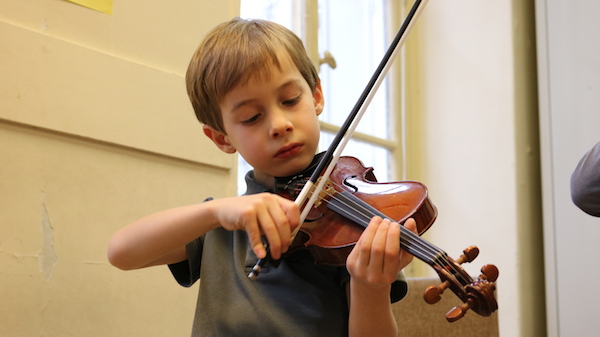

*** VGG16
(1, 3, 224, 224)
Predicted in 0.63 microseconds
[(0.96909326, 'n04536866 violin, fiddle'), (0.026661821, 'n02992211 cello, violoncello'), (0.0017283971, 'n02879718 bow'), (0.00056815607, 'n04517823 vacuum, vacuum cleaner'), (0.00024804618, 'n04090263 rifle')]
*** ResNet-152
(1, 3, 224, 224)
Predicted in 0.33 microseconds
[(0.96826923, 'n04536866 violin, fiddle'), (0.028052662, 'n02992211 cello, violoncello'), (0.0008367768, 'n02676566 acoustic guitar'), (0.00070531579, 'n02787622 banjo'), (0.0003902076, 'n02879718 bow')]
*** Inception v3
(1, 3, 224, 224)
Predicted in 0.09 microseconds
[(0.82023555, 'n04536866 violin, fiddle'), (0.15484105, 'n02992211 cello, violoncello'), (0.0044540642, 'n02676566 acoustic guitar'), (0.002096354, 'n02879718 bow'), (0.0015099689, 'n03447721 gong, tam-tam')]


In [8]:
image = "violin.jpg"

display(Image(filename=image))

topn = 5
print ("*** VGG16")
print (predict(image,vgg16,categories,topn))
print ("*** ResNet-152")
print (predict(image,resnet152,categories,topn))
print ("*** Inception v3")
print (predict(image,inceptionv3,categories,topn))


Let's try again with a **GPU context** this time

In [9]:
vgg16,categories = init("vgg16", gpu=True)
resnet152,categories = init("resnet-152", gpu=True)
inceptionv3,categories = init("Inception-BN", gpu=True)

print ("*** VGG16")
print (predict(image,vgg16,categories,topn))
print ("*** ResNet-152")
print (predict(image,resnet152,categories,topn))
print ("*** Inception v3")
print (predict(image,inceptionv3,categories,topn))


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
	prob_label
  warnings.warn(msg)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


*** VGG16
(1, 3, 224, 224)
Predicted in 0.03 microseconds
[(0.96909273, 'n04536866 violin, fiddle'), (0.02666183, 'n02992211 cello, violoncello'), (0.0017283944, 'n02879718 bow'), (0.00056815357, 'n04517823 vacuum, vacuum cleaner'), (0.00024804604, 'n04090263 rifle')]
*** ResNet-152
(1, 3, 224, 224)
Predicted in 0.05 microseconds
[(0.96826833, 'n04536866 violin, fiddle'), (0.028052796, 'n02992211 cello, violoncello'), (0.0008367768, 'n02676566 acoustic guitar'), (0.00070531643, 'n02787622 banjo'), (0.00039020577, 'n02879718 bow')]
*** Inception v3
(1, 3, 224, 224)
Predicted in 0.02 microseconds
[(0.82023585, 'n04536866 violin, fiddle'), (0.15484066, 'n02992211 cello, violoncello'), (0.0044540279, 'n02676566 acoustic guitar'), (0.0020963568, 'n02879718 bow'), (0.0015099607, 'n03447721 gong, tam-tam')]


***If you get an error about GPU support, either your machine or instance is not equipped with a GPU or you're using a version of MXNet that hasn't been built with GPU support (USE_CUDA=1)***

The difference in performance is quite noticeable: between **15x** and **20x**. If we predicted **multiple images** at the same time, the gap would widen even more due to the **massive parallelism** of GPU architectures.

Now it's time to try your **own images**. Just copy them in the same folder as this notebook, update the filename in the cell above and run the predict() calls again.

Have fun with pre-trained models!